---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

In this section, the goal is to build machine learning models to investigate the drivers of our target variables, chronic absenteeism, dropout risk, and college persistence. We will build three different models: a regression, a binary classification, and a multivariate classification. For each one, we will test different models and find which works best. 

I created a few functions to streamline our modeling process. These include preprocessing, train, tune, scoring the validation set, and scoring the test set.

*Preprocessing*: this function takes in a dataframe, target column, and test size. It then splits the data into training, validation, and test sets. The training is used to train our models on the subset of the data, the validation set is vital for tuning our hyperparameters, the test set is used to evaluate our model on new unseen data.

*Train*: This function takes in  an X_train, y_train, learning_task_type, model_type, **kwargs. Learning task type should be 'classification' or 'regression', and model_type should be the algorithm you are trying to use. **kwargs allows you to pass algorithm arugments into the function, this will usually be used once we have tuned.

*Tune*: This function takes in a model, X_train, y_train, param_grid, and scoring=None. This function is used for cross validation in order to tune our hyperparamters. We have created a random forest and gradient boosting parameter grid so that the function can perform a grid search over these values and find the optimal parameters. The scoring parameter is used to specify what metric we are trying to maximize, this depends on our goal

*Validation Scoring*: This function evaluates how our validation set is performing so that we can then tune our hyperparameters. It takes in learning_task_type, model, X_val, y_val. For regression it outputs MAE, RMSE and R2, for classification it outputs our confusion matrix.

*Evaluate Test*: This function is our last step, evaluating our test data. It takes in learning_task_type, model, X_test, y_test and outputs our regression and classification metrics for our now tuned model.

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

import statsmodels.api as sm
from scipy import stats

In [245]:
df = pd.read_csv('../../data/processed-data/processed_df.csv', index_col=None)

In [246]:
# Drop categorical and identifier columns we dont need
df.drop(columns=['DBN', 'School Name', 'District', 'zip code', 'Borough'], inplace=True)
#drop columns that cause perfect multicollinearity
df_clean = df.drop(['Median Household Income',"Percent Bachelor's Degree or Higher (25+)",'Percent No High School (25+)','Student Percent - Other', 'Percent Female','Percent who took ACT','Percent College Ready based on SAT Math'], axis=1)

In [128]:
def preprocessing(df, target_column, test_size=0.2):
       """Splits the data into training and test sets."""
       X = df.drop(columns=[target_column])
       y = df[target_column]
       #split into training, validation, test set
       X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
       X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=test_size, shuffle=True)
       #standardize
       scaler = StandardScaler()
       X_train = scaler.fit_transform(X_train)
       X_val = scaler.transform(X_val)
       X_test = scaler.transform(X_test)
       #y_train = scaler.fit_transform(y_train)
       #y_val = scaler.fit_transform(y_val)
       #y_test = scaler.fit_transform(y_test)
       return X, y, X_train, X_val, X_test, y_train, y_val, y_test

In [80]:
def train(X_train, y_train, learning_task_type, model_type, **kwargs):
    """Trains a machine learning model."""
    if learning_task_type == 'regression':
        if model_type == 'random_forest':
            model = RandomForestRegressor(**kwargs)
        elif model_type == 'linear_regression':
            model = LinearRegression(**kwargs)
        elif model_type == 'gradient_boosting':
            model = GradientBoostingRegressor(**kwargs)
        else:
            raise ValueError("Invalid regression model type: Choose 'random_forest', 'linear_regression', or 'gradient_boosting'.")
    elif learning_task_type == 'classification':
        if model_type == 'random_forest':
            model = RandomForestClassifier(**kwargs)
        elif model_type == 'gradient_boosting':
            model = GradientBoostingClassifier(**kwargs)
        else:
            raise ValueError("Invalid classification model type: Choose 'random_forest' or 'gradient_boosting'.")
    else:
        raise ValueError("Learning types: ['classification','regression'] \n Model types: ['linear_regression','random_forest','gradient_boosting']")
    model.fit(X_train, y_train)
    return model

In [81]:
def tune(model, X_train, y_train, param_grid, scoring=None):
    """Performs hyper-parameter tuning."""
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    print(f"Best params: {grid_search.best_params_}")
    return model

In [82]:
def validation_eval(learning_task_type, model, X_val, y_val):
    y_pred = model.predict(X_val)

    if learning_task_type == 'regression':
        MAE = mean_absolute_error(y_val, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        R2 = r2_score(y_val, y_pred)

        print(f"Mean Absolute Error (MAE): {MAE:.4f}")
        print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
        print(f"R-squared: {R2:.4f}")
    
    elif learning_task_type == 'classification':
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    
    else:
        raise ValueError("Unsupported learning task type: 'regression' or 'classification'")

    return y_pred

In [83]:
def evaluate_test(learning_task_type, model, X_test, y_test):
    """Evaluates the model on new data or the test set."""
    y_pred = model.predict(X_test)
    
    if learning_task_type == 'regression':
        MAE = mean_absolute_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        R2 = r2_score(y_test, y_pred)

        print(f"Mean Absolute Error (MAE): {MAE:.4f}")
        print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
        print(f"R-squared: {R2:.4f}")
        
    elif learning_task_type == 'classification':
        print("Classification Report:", classification_report(y_test, y_pred))
    else:
        raise ValueError("Unsupported learning task type: 'regression' or 'classification'")
    
    return y_pred

In [321]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [5, 15, 20],  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True, False] 
}

boost_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 5, 10], 
    'max_features': ['sqrt', 'log2']  
}

In [271]:
subset = df_clean[['Average Grade 8 Proficiency',
    'Metric Value - College Persistence',
    'Supportive Environment - Element Score',
    'Graduation Rate',
    'Metric Value - Average Regents Score - English',
    'Metric Value - College and Career Preparatory Course Index',
    'Percent with 20+ ACT',
    'Percent HRA Eligible',
    'Student Percent - Black and Hispanic',
    'Percent Students with IEPs',
    'dropout_rate',
    'Percent in Temp Housing',
    'Percent Overage / Undercredited',
    'Percent of Students Chronically Absent'
]]


In [272]:
subset['log_dropout_rate'] = np.log(subset['dropout_rate'] + 1)
subset['log_temp_housing'] = np.log(subset['Percent in Temp Housing'] + 1)
subset['log_percent_overage'] = np.log(subset['Percent Overage / Undercredited'] + 1)

/var/folders/hl/7yl66vtn2mn30d649bqpv1wc0000gn/T/ipykernel_85734/3082819323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['log_dropout_rate'] = np.log(subset['dropout_rate'] + 1)
/var/folders/hl/7yl66vtn2mn30d649bqpv1wc0000gn/T/ipykernel_85734/3082819323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['log_temp_housing'] = np.log(subset['Percent in Temp Housing'] + 1)
/var/folders/hl/7yl66vtn2mn30d649bqpv1wc0000gn/T/ipykernel_85734/3082819323.py:3: SettingWithCopyWarning: 
A value is

In [273]:
subset2 = subset[['Average Grade 8 Proficiency',
    'Metric Value - College Persistence',
    'Supportive Environment - Element Score',
    'Graduation Rate',
    'Metric Value - Average Regents Score - English',
    'Metric Value - College and Career Preparatory Course Index',
    'Percent with 20+ ACT',
    'Percent HRA Eligible',
    'Student Percent - Black and Hispanic',
    'Percent Students with IEPs',
    'Percent of Students Chronically Absent',
    'log_dropout_rate', 'log_temp_housing','log_percent_overage'
]]

## Regression

Regression is supervised learning task used to find a relationships between continous data. We have one variable of interest that we will call our dependent variable, and many independent features that we will be regressing on, because we hypothesize that they have a relationship to our dependent variable. The strength of these relationships will be quantified by the independent variables coefficient. In this case, our goal is to try and find drivers of chronic absenteeism. With these outputs, schools can intervene and attempt to reduce chronic abseentism in New York City Public Schools.

Target Variable: **Percent of Students Chronically Absent**

### LASSO Regression

LASSO is a regularization technique known as L1 Regularization that is a good option in this case because of its ability to work high dimensional data. Although LASSO stands for Least Absolute Shrinkage and Selection Operator, we can think of it like a rope lasso that is thrown around all the features, but filters from its catch the variables that dont contribute to our model, by pushing their coefficients to 0. It does this by introducing a regularization hyperparamter, that we will tune to help shrink the coefficicents. This will help us perform feature selection automatically, and find the importance of the terms we are left with.


In [300]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_clean, target_column='Percent of Students Chronically Absent')

Validation MSE: 0.016715274716061178
Validation R-sq: 0.4155828485639558


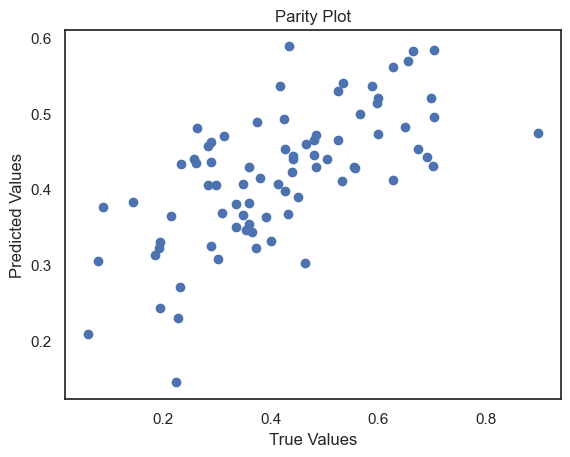

In [302]:
lasso = Lasso(alpha=0.01) 
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_val)

print("Validation MSE:", mean_squared_error(y_val, y_val_pred))
print("Validation R-sq:", lasso.score(X_val, y_val))

plt.scatter(y_val, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

To tune our hyperparamter, we will use scikit-learn's cross validation tool specifically for Lasso regression, LassoCV to find the optimal choice for alpha

In [303]:
lasso_cv = LassoCV(alphas=[0.1, 0.01, 0.05, 0.001, 0.005, 0.0005, 0.0001], cv=5)
lasso_cv.fit(X_train, y_train)
print(f"Optimal alpha: {lasso_cv.alpha_}")

Optimal alpha: 0.005


Evaluation MSE: 0.014213076581525154
Evaluation R-sq: 0.5153849990622177


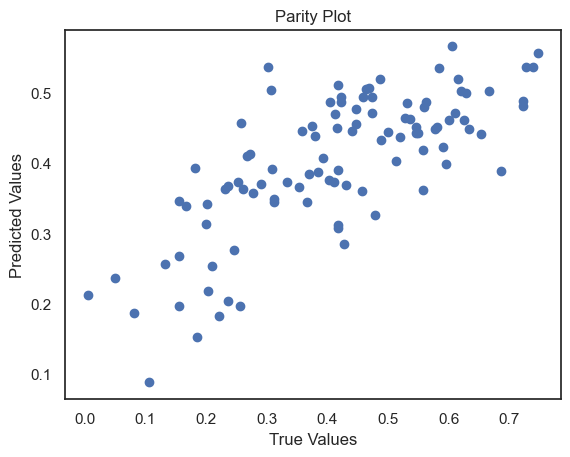

In [305]:
# input tuned alpha and evalate using test data
lasso = Lasso(alpha=0.005)
lasso.fit(X_train, y_train)

# get evaluation scores after tuning
y_pred = lasso.predict(X_test)

print("Evaluation MSE:", mean_squared_error(y_test, y_pred))
print("Evaluation R-sq:", lasso.score(X_test, y_test))

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

Our model fit has improved and our MSE has decreased using our tuned hyperparameter. 

Now, using the absolute value of the coefficients, we can visualize the features that are most relevant to our target variable

<Figure size 1000x600 with 0 Axes>

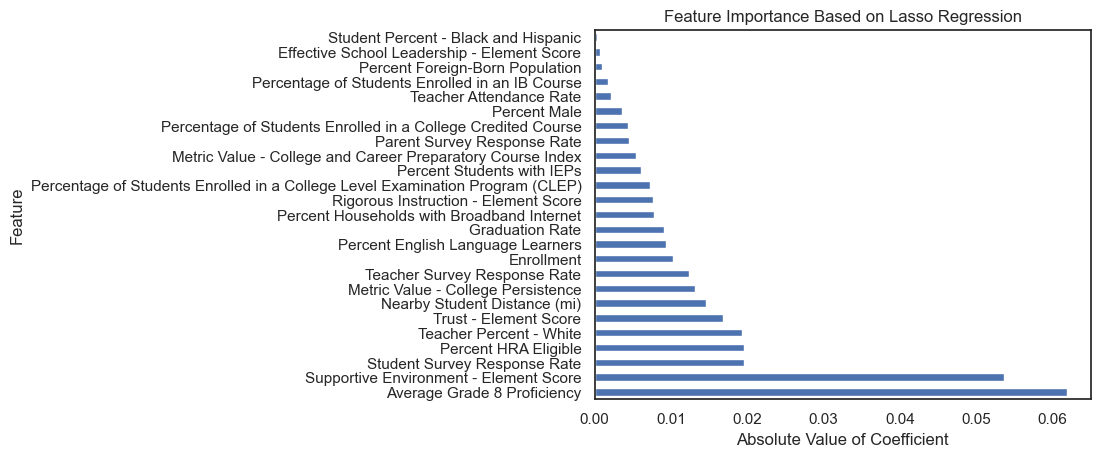

In [306]:
feature_names = X.columns
coefs = lasso.coef_

coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})


coefs_df['abs_val_coef'] = coef_df['Coefficient'].abs()
coefs_df = coefs_df.sort_values(by='abs_val_coef', ascending=False)

coefs_df = coefs_df.loc[coefs_df['abs_val_coef']>0]

plt.figure(figsize=(10, 6))
coefs_df.plot(kind='barh', x='Feature', y='abs_val_coef', legend=False)
plt.xlabel('Absolute Value of Coefficient')
plt.title('Feature Importance Based on Lasso Regression')
plt.show()


### Linear Regression - TBD

In [274]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = subset2, target_column='Percent of Students Chronically Absent')

In [275]:
model = train(X_train, y_train, 'regression', 'linear_regression')
y_pred = validation_eval('regression', model, X_val, y_val)

Mean Absolute Error (MAE): 0.0916
Root Mean Squared Error (RMSE): 0.1174
R-squared: 0.3906


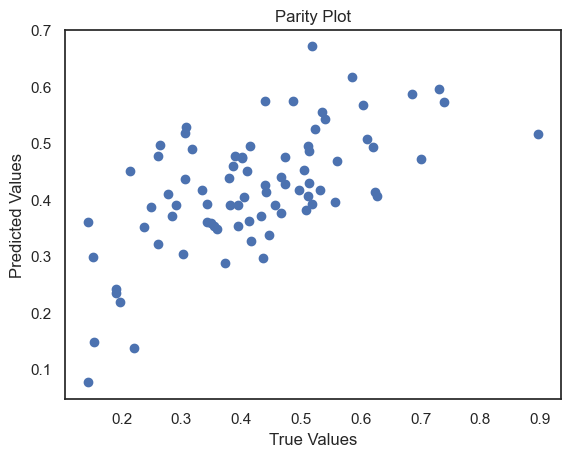

In [276]:
plt.scatter(y_val, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

In [277]:
y_pred = evaluate_test('regression', model, X_test, y_test)

Mean Absolute Error (MAE): 0.0891
Root Mean Squared Error (RMSE): 0.1100
R-squared: 0.4163


### Random Forest Regression

Random Forest is a supervised learning task that is an ensemble of many decision trees. Simply, decision trees work by starting at a root node and split depending on questions asked at each successive node. Random Forest is just many decision trees working together. It is superior to single decision trees becasue it prevents overfitting by averaging the outcome of the indivudual trees to get the final result. In addition, it is less sensitive to multicollinearity and normalization than other regression methods and can learn non-linear boundaries.

There are a few important hyperparamters to tune in random forest regression. This includes n_estimators (the number of trees in the forest), max_depth (the maximum depth or number of splits each tree makes), max_features (how many features are considered for splits), and bootstrap (whether boostrapping should be used (resampling with replacement)) (https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

When we boostrap, this is considered a bagging method (Bootstrap Aggregating).

We will attempt to run random forest regressor and see if it improves our results.

In [313]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df_clean, 'Percent of Students Chronically Absent')

In [314]:
model = train(X_train, y_train, 'regression', 'random_forest')
y_pred = validation_eval('regression',model,  X_val, y_val)

Mean Absolute Error (MAE): 0.0903
Root Mean Squared Error (RMSE): 0.1170
R-squared: 0.4544


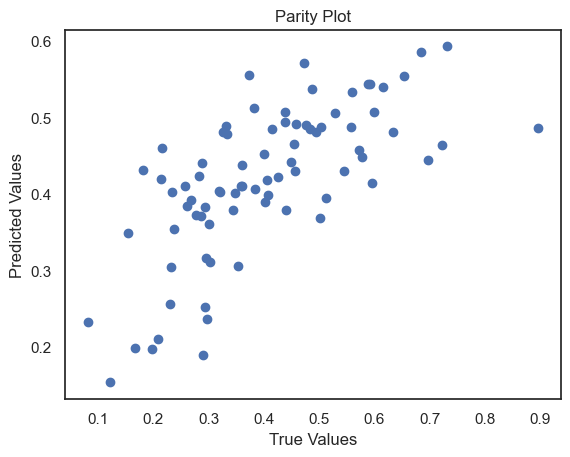

In [315]:
plt.scatter(y_val, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

Tune and Retrain Model

In [310]:
tune(model, X_train, y_train, rf_param_grid, scoring='neg_mean_squared_error')

Best params: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}


RandomForestRegressor(max_depth=15, max_features='sqrt')

In [284]:
model = train(X_train, y_train, 'regression', 'random_forest', bootstrap = True, max_depth= 20, max_features= 'sqrt', n_estimators= 200)

A handy output of Random Forest is feature importance. Now we can see which features are most important to our target variable.

In [316]:
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

<Figure size 1000x600 with 0 Axes>

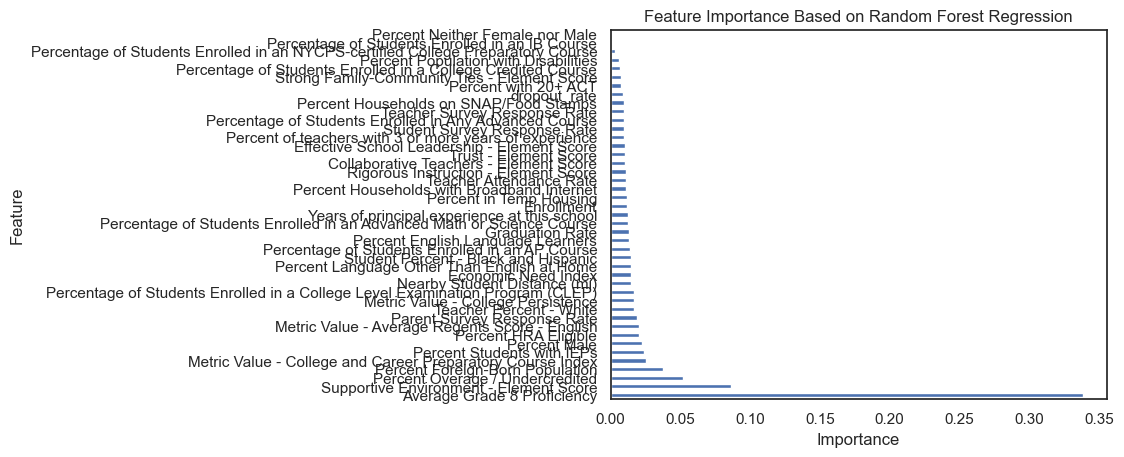

In [317]:
plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.xlabel('Importance')
plt.title('Feature Importance Based on Random Forest Regression')
plt.show()

In [318]:
y_pred = evaluate_test('regression', model, X_test, y_test)

Mean Absolute Error (MAE): 0.0856
Root Mean Squared Error (RMSE): 0.1049
R-squared: 0.5322


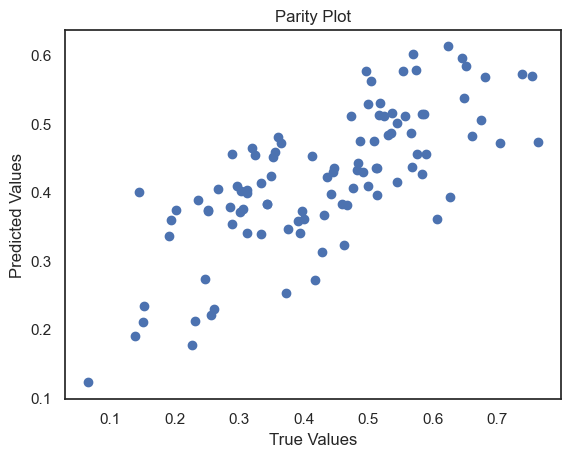

In [319]:
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

### Gradient Boosting Regression

We will try one more regression algorithm to see if we can improve our results.

Contrary to our previous bagging method, we will now attempt a boosting method. In boosting, trees are grown sequentially rather than parallel in bagging. We now do random sampling with replacement over weighted data. This allows the tree to learn from previous models and correct itself, aggregating weak learners into a strong learner and optimizing the output.

The important hyperparameters to tune in gradient boosting are learning rate (controls for the contribution of each tree), n_estimators (number of trees), max_depth (controls number of nodes in the tree), and max_features (number of features to consider for splits) (https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

In [327]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(subset2, 'Percent of Students Chronically Absent')

In [323]:
model = train(X_train, y_train, 'regression', 'gradient_boosting')
y_pred = validation_eval('regression', model,  X_val, y_val)

Mean Absolute Error (MAE): 0.1084
Root Mean Squared Error (RMSE): 0.1366
R-squared: 0.3340


In [324]:
model = tune(model, X_train, y_train, boost_param_grid, scoring='neg_mean_squared_error')

Best params: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}


In [325]:
model = train(X_train, y_train, 'regression', 'gradient_boosting', learning_rate= 0.05, max_depth= 5, max_features= 'log2', n_estimators= 50)
y_pred = validation_eval('regression', model,  X_val, y_val)

Mean Absolute Error (MAE): 0.1031
Root Mean Squared Error (RMSE): 0.1305
R-squared: 0.3925


In [326]:
y_pred = evaluate_test('regression', model, X_test, y_test)

Mean Absolute Error (MAE): 0.0963
Root Mean Squared Error (RMSE): 0.1276
R-squared: 0.3839


## Binary Classification

Binary Classification is an algorithm used for categorical variables. Since this is a supervised learning algorithm, we are predicting predefined class labels. In binary classification, the target variable only has two possible classes. We want to train a model that correctly predicts the correct classes as much as possible. The best way to evaluate the output of a classification task is by visualizing a confusion matrix. From there, we can calculate a few metrics including accuracy, precision, recall, and F1 score. The metric that we try to maximize will depend on the classification problem. 

The calculations are as follows:
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$
$$
\text{Precision} = \frac{TP}{TP + FP}
$$
$$
\text{Recall} = \frac{TP}{TP + FN}
$$
F1 is the harmonic balance of precision and recall, calculated as: 
$$
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Our target variable is: **High Schools with high vs. low dropout risk**

In our case, accuracy is not a good metric since our classes are unbalanced. The worst-case scenario in our classification problem is a school that is overlooked and not identified as having high dropout risk. Therefore, if we treat our positive class as high schools with high dropout risk, we want to minimize false negatives (also known as Type II error) and maximize our recall score. We will use cross-validation to try to find the best algorithm that does this.

First, we will create our binary high dropout risk variable. We will use the 75th percentile and above of the dropout rate distribution to classify a high school as "high risk". We will also drop Graduation Rate, as it may introduce data leakage.

In [265]:
print(df_clean['dropout_rate'].describe())

count    501.000000
mean       5.358034
std        5.261403
min        0.000000
25%        1.225000
50%        3.700000
75%        7.700000
max       27.650000
Name: dropout_rate, dtype: float64


In [266]:
df_class = df_clean.copy()
df_class['high_dropout'] = [1 if x >= 7.7 else 0 for x in df_class['dropout_rate']]
df_class.drop(['dropout_rate','Graduation Rate'], axis=1, inplace=True)

### Random Forest Classification

First we will try a Random Forest classifier. This is similar to the random forest regressor we tried earlier, except now the trees are making a prediction of what class the data belongs to rather than a continous variable. Instead of taking the average of all the trees, the outcome is a majority vote to decide the final output.

In [424]:
X, X_scaled, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_class, target_column='high_dropout')

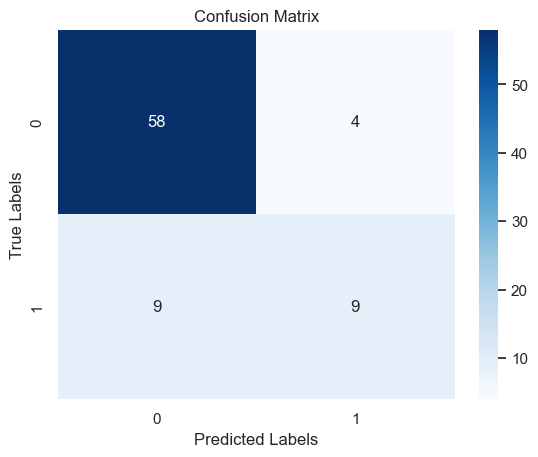

In [425]:
model = train(X_train, y_train, 'classification', 'random_forest')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [426]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.82      0.96      0.88        72
           1       0.82      0.48      0.61        29

    accuracy                           0.82       101
   macro avg       0.82      0.72      0.75       101
weighted avg       0.82      0.82      0.81       101



In [430]:
model = tune(model, X_train, y_train, rf_param_grid, scoring='f1')

Best params: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}


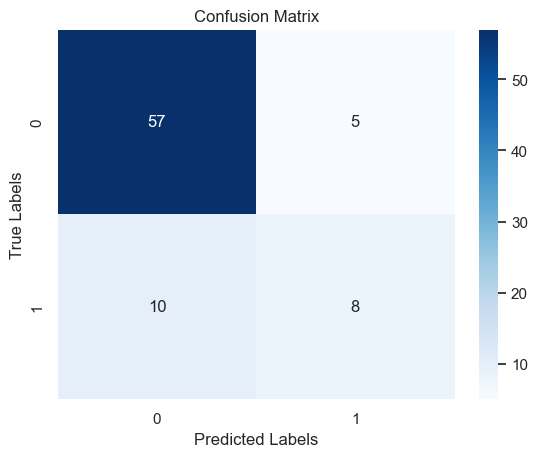

In [431]:
model = train(X_train, y_train, 'classification', 'random_forest', bootstrap=True, max_depth=20, max_features='log2', n_estimators=100)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [432]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.81      0.96      0.88        72
           1       0.81      0.45      0.58        29

    accuracy                           0.81       101
   macro avg       0.81      0.70      0.73       101
weighted avg       0.81      0.81      0.79       101



### Gradient Boosting Classification

Next, we will try a Gradient Boosting Classifier. This is similar to the gradient boosting regressor we tried earlier, except now the trees are using boosting to making a prediction of the class the data belongs to. Just like our Random Forest Classifier, the trees will majority vote to decide the final output.

In [464]:
X, X_scaled, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_class, target_column='high_dropout')

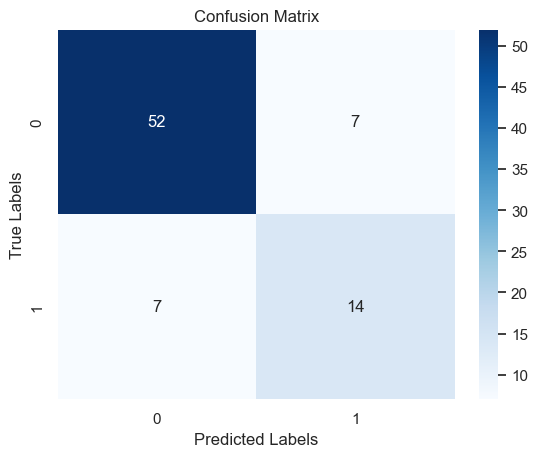

In [465]:
model = train(X_train, y_train, 'classification', 'gradient_boosting')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [466]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.86      0.85      0.86        82
           1       0.40      0.42      0.41        19

    accuracy                           0.77       101
   macro avg       0.63      0.64      0.63       101
weighted avg       0.78      0.77      0.77       101



In [472]:
model = tune(model, X_train, y_train, boost_param_grid, scoring='f1')

Best params: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}


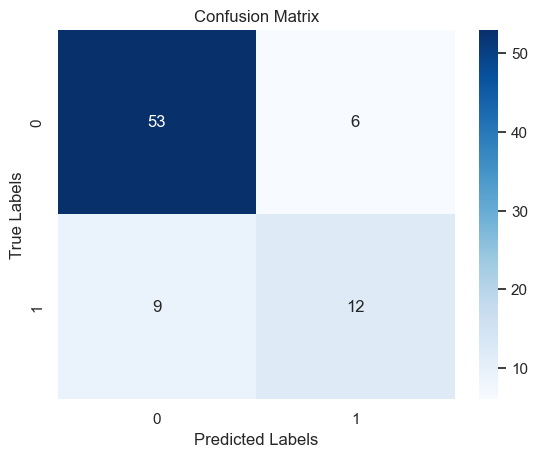

In [473]:
model = train(X_train, y_train, 'classification', 'gradient_boosting', max_depth=10, max_features='log2', n_estimators=200)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [474]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.87      0.90      0.89        82
           1       0.50      0.42      0.46        19

    accuracy                           0.81       101
   macro avg       0.69      0.66      0.67       101
weighted avg       0.80      0.81      0.81       101



## Multiclass Classification

Multiclass Classification is the same idea as Binary Classification, except now we have more than 2 classes we are trying to predict. Here, we are interested in classifying high schools with low, medium and high rates of college persistence. In our binary classification, we attempted to classify high schools with high drop out risk rate. However, if a high school is marked safe as having low dropout risk, we still want to intervene if the high school has low rates of college persistence. It is a great accomplishment to prevent drop out from high school, but we also want to these values to translate to college and prevent drop out from higher education.

Target: **Classifying high schools with low, medium and high collge persistence**

First, we will divide our College Persitance distribution into 3 bins, labeling these categories as Low, Medium, and High.

In [328]:
df_multi = df_clean.copy()
df_multi['college_persistence_ranking'] = pd.cut(df_multi['Metric Value - College Persistence'], bins=3, labels=['Low','Medium','High'])
df_multi.drop(['Metric Value - College Persistence'], axis=1, inplace=True)

### Random Forest Classifier
We will test how well a Random Forest Classifier predicts our labels, this time for three classes 

In [334]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_multi, target_column='college_persistence_ranking')

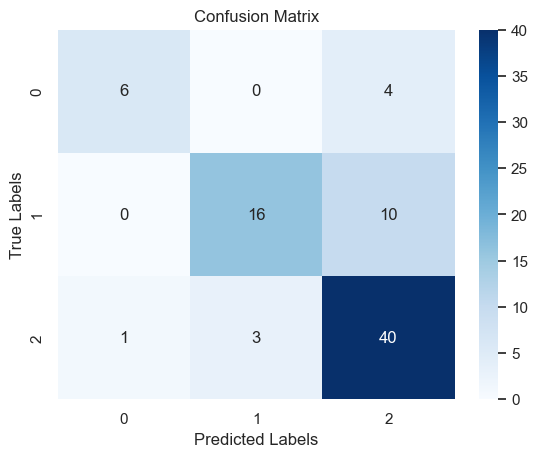

In [335]:
model = train(X_train, y_train, 'classification', 'random_forest')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [336]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       0.94      0.71      0.81        24
         Low       0.75      0.55      0.63        22
      Medium       0.75      0.91      0.82        55

    accuracy                           0.78       101
   macro avg       0.81      0.72      0.75       101
weighted avg       0.79      0.78      0.78       101



In [337]:
model = tune(model, X_train, y_train, rf_param_grid)

Best params: {'bootstrap': True, 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 50}


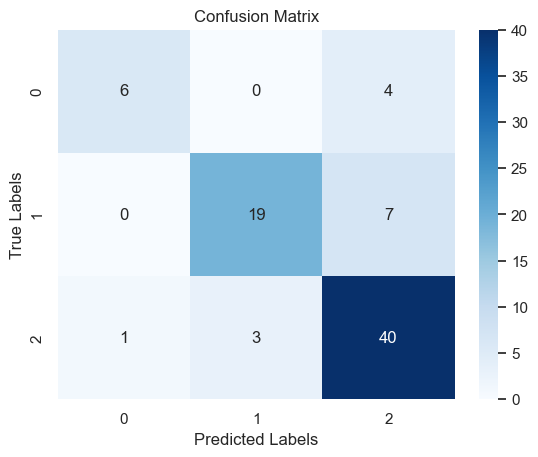

In [338]:
model = train(X_train, y_train, 'classification', 'random_forest', bootstrap=True, max_depth=15, max_features='log2', n_estimators=50)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [339]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       1.00      0.71      0.83        24
         Low       0.69      0.50      0.58        22
      Medium       0.74      0.91      0.81        55

    accuracy                           0.77       101
   macro avg       0.81      0.71      0.74       101
weighted avg       0.79      0.77      0.77       101



### Gradient Boosting

Now we will attempt a Gradient Boosting Classifier and see if it improves upon the Random Forest Classifier

In [341]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_multi, target_column='college_persistence_ranking')

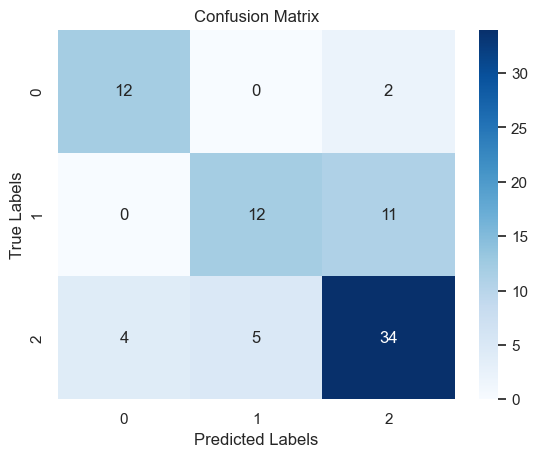

In [342]:
model = train(X_train, y_train, 'classification', 'gradient_boosting')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [343]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       1.00      0.86      0.92        14
         Low       0.70      0.70      0.70        27
      Medium       0.84      0.87      0.85        60

    accuracy                           0.82       101
   macro avg       0.85      0.81      0.83       101
weighted avg       0.82      0.82      0.82       101



In [347]:
model = tune(model, X_train, y_train, boost_param_grid, scoring = 'f1_weighted')

Best params: {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}


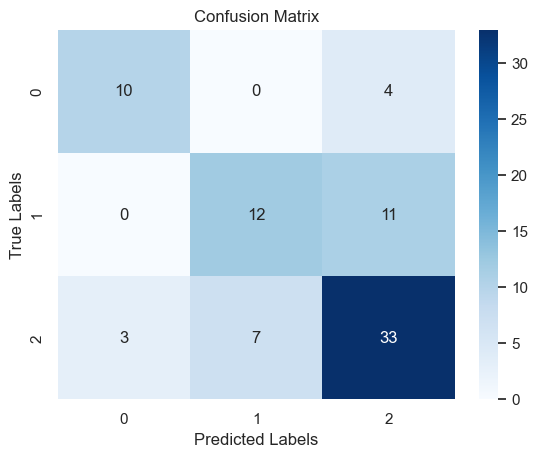

In [345]:
model = train(X_train, y_train, 'classification', 'gradient_boosting', learning_rate = 0.05, max_depth=3, max_features='sqrt', n_estimators=100)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [346]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       1.00      0.71      0.83        14
         Low       0.65      0.56      0.60        27
      Medium       0.76      0.87      0.81        60

    accuracy                           0.76       101
   macro avg       0.81      0.71      0.75       101
weighted avg       0.77      0.76      0.76       101

